In [1]:
import torch
import torch.nn as nn
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(0)

class PINN(nn.Module):
    def __init__(self,data, layers, act=nn.Tanh()):
        super().__init__()
        self.data = {k: v.to(device) for k, v in data.items()}
        self.layers = layers
        self.act = act
        self.criterion = nn.MSELoss()
        
        
        modules = []
        for i in range(len(layers) - 2):
            modules.append(nn.Linear(layers[i], layers[i + 1]))
            nn.init.xavier_normal_(modules[-1].weight)
            modules.append(self.act)
        
        modules.append(nn.Linear(layers[-2], layers[-1]))
        nn.init.xavier_normal_(modules[-1].weight)
        self.net = nn.Sequential(*modules)


    def forward(self, x, t):
        return self.net(torch.cat([x, t], dim=1))

    def compute_PDE_loss(self,c=1):
        x_f = self.prep_tensor(self.data["x_f"], requires_grad=True)
        t_f = self.prep_tensor(self.data["t_f"], requires_grad=True)

        u_f = self(x_f,t_f)
        u_dx, u_dt = grad(u_f, (x_f, t_f), torch.ones_like(u_f),retain_graph=True, create_graph=True)
        u_ddx = grad(u_dx, x_f, torch.ones_like(u_f),create_graph=True)[0]
        u_ddt = grad(u_dt, t_f, torch.ones_like(u_f),create_graph=True)[0]

        residual = u_ddt - u_ddx*c**2
        residual = torch.mean(residual**2)
    
        return residual

    def compute_boundary_loss(self):
        x_bc = self.prep_tensor(self.data["x_bc"])
        t_bc = self.prep_tensor(self.data["t_bc"])
        u_bc = self.prep_tensor(self.data["u_bc"])

        u_bc_pred = self(x_bc,t_bc)
        bc_loss = torch.mean((u_bc_pred - u_bc)**2)
        return bc_loss
    
    def compute_initial_condition_loss(self):
        x_ic = self.prep_tensor(self.data["x_ic"], requires_grad=True)
        t_ic = self.prep_tensor(self.data["t_ic"], requires_grad=True)
        u_ic = self.prep_tensor(self.data["u_ic"], requires_grad=True)
        u_t_ic = self.prep_tensor(self.data["u_t_ic"])

        u_ic_pred = self(x_ic,t_ic)
        u_t = grad(u_ic_pred, t_ic, torch.ones_like(u_ic_pred), create_graph=True)[0]
        ic_loss = torch.mean((u_ic_pred - u_ic)**2) + torch.mean((u_t - u_t_ic)**2)
        return ic_loss

    def compute_data_loss(self):
        x_data = self.prep_tensor(self.data["x_data"], requires_grad=True)
        t_data = self.prep_tensor(self.data["t_data"], requires_grad=True)
        u_data = self.prep_tensor(self.data["u_data"])

        u_data_pred = self(x_data,t_data)
        data_loss = torch.mean((u_data_pred - u_data)**2)
        return data_loss

    def compute_total_loss(self, lambda_f=1.0, lambda_bc=1.0, lambda_ic=1.0, lambda_data=1.0):
        pde_loss = self.compute_PDE_loss()
        bc_loss = self.compute_boundary_loss()
        ic_loss = self.compute_initial_condition_loss()
        data_loss = self.compute_data_loss()
        
        total_loss = lambda_f*pde_loss + lambda_bc*bc_loss + lambda_ic*ic_loss + lambda_data*data_loss
        
        loss_for_display = {
            "total_loss": total_loss.item(),
            "pde_loss": lambda_f*pde_loss.item(),
            "bc_loss": lambda_bc*bc_loss.item(),
            "ic_loss": lambda_ic*ic_loss.item(),
            "data_loss": lambda_data*data_loss.item()}
        
        return total_loss, loss_for_display

    def prep_tensor(self, x, requires_grad=False):
        return x.clone().detach().to(device).requires_grad_(requires_grad)

    def train_model(self, niter):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        for it in range(niter):
            optimizer.zero_grad()
            loss, loss_for_display = self.compute_total_loss()
            loss.backward()
            optimizer.step()
            # break
            if it % 200 == 0:
                print(f"Iter: {it}, Loss: {loss.item():.4e}, PDE Loss: {loss_for_display['pde_loss']:.4e}, BC Loss: {loss_for_display['bc_loss']:.4e}, IC Loss: {loss_for_display['ic_loss']:.4e}, Data Loss: {loss_for_display['data_loss']:.4e}")
    
    def predict(self, x, t):
        x = x.clone().detach().to(device)
        t = t.clone().detach().to(device)
        u = self(x,t)
        return u.detach().cpu().numpy()

N_bc = 100
N_ic = 100
N_f = 20000
t_end = 3*np.pi
# Define boundary conditions
x_bc = torch.cat([torch.zeros(N_bc, 1), torch.ones(N_bc, 1)])*np.pi
t_bc = torch.rand(2*N_bc, 1, requires_grad=True)*t_end
u_bc = torch.ones((2*N_bc, 1))*0.0

# Define initial conditions
x_ic = torch.rand(N_ic, 1)*np.pi
t_ic = torch.zeros(N_ic, 1)
u_ic = torch.zeros(N_ic, 1)
u_t_ic = torch.sin(x_ic)

#Define PDE collocation points
def u_sol(t,x,n,Kn = 1,l = np.pi,c = 1):
        return Kn*np.sin(n*np.pi/l*(c*t))*np.sin(n*np.pi/l*x)

x_f = torch.rand(N_f, 1)*np.pi
t_f = torch.rand(N_f, 1)*t_end
# u_f = u_sol(t_f,x_f,n =1)

#Defining the data points
N_data = 100
x_data = torch.rand(N_data, 1)*np.pi/2
t_data = torch.rand(N_data, 1)*1.0
u_data = u_sol(t_data,x_data,n =1)+torch.rand(N_data, 1)*0.1
# t_data = torch.tensor([[0.0]])
# u_data = torch.tensor([[0.0]])

data = {
    "x_bc": x_bc, "t_bc": t_bc, "u_bc": u_bc,
    "x_ic": x_ic, "t_ic": t_ic, "u_ic": u_ic, "u_t_ic": u_t_ic,
    "x_f": x_f, "t_f": t_f,
    "x_data": x_data, "t_data": t_data, "u_data": u_data
}

layers = [2,40,40,40,40,40,40,40,1]
model = PINN(data, layers).to(device)

#Gathering everything needed for model setup in data

# model.compute_total_loss(x,t,torch.tensor([[0.0]],device=device))
# model.compute_boundary_loss()
model.train_model(100)








/zhome/59/9/137222/mambaforge/envs/PDE1/lib/python3.12/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Iter: 0, Loss: 6.8310e-01, PDE Loss: 7.3556e-03, BC Loss: 9.4955e-02, IC Loss: 4.9169e-01, Data Loss: 8.9101e-02


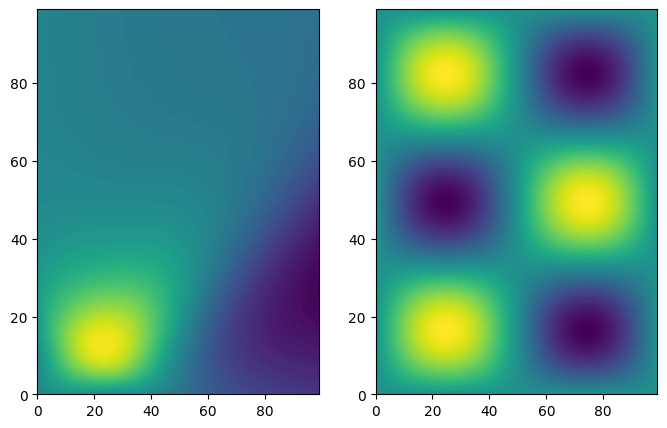

In [2]:
t_val = torch.linspace(0, 3, 100)  # Example: evaluate at the midpoint of the time domain

X_test = torch.linspace(0, np.pi*2, 100).reshape(-1, 1)
T_test = torch.linspace(0, t_end, 100).reshape(-1, 1)
u_pred = np.zeros((100,100))
u_true = np.zeros((100,100))
for i, t in enumerate(T_test):
    t_temp = torch.ones_like(X_test)*t
    u_pred[i] = model.predict(X_test, t_temp)[:,0]
    # print(t.shape)
    u_true[i] = u_sol(t, X_test[:,0], n=1)
    # break
# u_true = u_sol(T_test, X_test.numpy(), n=1)
fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].contourf(u_pred, levels=100, cmap='viridis')
ax[1].contourf(u_true, levels=100, cmap='viridis')
# ax[0].plot(X_test, u_pred, label='Predicted', color='blue')
# ax[0].plot(X_test, u_true, label='Exact', color='red', linestyle='dashed')


In [ ]:
import torch
import torch.nn as nn
from torch.autograd.functional import jacobian
import numpy as np
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(0)

class SD_PINN(nn.Module):
    def __init__(self,data, layers, act=nn.Tanh()):
        super().__init__()
        self.data = {k: v.to(device) for k, v in data.items()}
        self.layers = layers
        self.act = act
        self.criterion = nn.MSELoss()
        
        modules = []
        for i in range(len(layers) - 2):
            modules.append(nn.Linear(layers[i], layers[i + 1]))
            nn.init.xavier_normal_(modules[-1].weight)
            modules.append(self.act)
        
        modules.append(nn.Linear(layers[-2], layers[-1]))
        nn.init.xavier_normal_(modules[-1].weight)
        self.net = nn.Sequential(*modules)

    def forward(self, s, t):
        return self.net(torch.cat([s, t], dim=1))
    
    def compute_boundary_loss(self):
        t_bc = self.data["t_bc"]
        x_bc = torch.ones_like(t_bc)
        # print(f"x.shape: {x_bc.device}, t_bc.shape: {t_bc.device}")
        u_pred = self(x_bc,t_bc)
        
        # print(f"u_bc_pred.shape: {u_pred.shape}")
        target = torch.zeros_like(u_pred[:,0])
        bc_loss = self.criterion(u_pred[:,0], target)+self.criterion(u_pred[:,-1], target)
        return bc_loss
    
    def compute_PDE_loss(self,s,t,c=1):
        t = self.prep_tensor(t, requires_grad=True)
        u_pred = self(s,t)
        print(u_pred.shape)
        u_dt = grad(u_pred, t, torch.ones_like(u_pred),retain_graph=True, create_graph=True)[0]
        print(u_dt.shape)
        u_ddt = grad(u_dt, t, torch.ones_like(u_dt),create_graph=True)[0]
        return
    def compute_data_loss(self,s,t,u_data):

        u_data_pred = self(s,t)
        data_loss = self.criterion(u_data_pred, u_data)
        return data_loss
    
    def compute_total_loss(self,x,t,u_data, lambda_bc=1.0, lambda_data=1.0):
        # bc_loss = self.compute_boundary_loss(x)
        data_loss = self.compute_data_loss(x,t,u_data)
        
        total_loss = lambda_data*data_loss#+lambda_bc*bc_loss 
        
        loss_for_display = {
            "total_loss": total_loss.item(),
            # "bc_loss": lambda_bc*bc_loss.item(),
            "data_loss": lambda_data*data_loss.item()}
        
        return total_loss, loss_for_display
    
    def train_model(self,x,t,u_data, niter):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        for it in range(niter):
            optimizer.zero_grad()
            loss, loss_for_display = self.compute_total_loss(x,t,u_data)
            loss.backward()
            optimizer.step()
            # break
            if it % 200 == 0:
                print(f"Iter: {it}, Loss: {loss.item():.4e}, Data Loss: {loss_for_display['data_loss']:.4e}")
        
    
    def prep_tensor(self, x, requires_grad=False):
        return x.clone().detach().requires_grad_(requires_grad)  

N_bc = 10
N_ic = 10
# N_f = 20000
t_end = 3*np.pi
# Define boundary conditions
x_bc = torch.cat([torch.zeros(N_bc, 1), torch.ones(N_bc, 1)])*np.pi
t_bc = torch.rand(2*N_bc, 1, requires_grad=True)*t_end
u_bc = torch.ones((2*N_bc, 1))*0.0    
data_SD = {
    "x_bc": x_bc, "t_bc": t_bc, "u_bc": u_bc,
}

N_sensors = 5
spatial_resolution = 100
sensor_loc = torch.arange(0, spatial_resolution, spatial_resolution//N_sensors)
t = torch.tensor([[1.0]])
x_full = torch.linspace(0, np.pi, spatial_resolution)
u = u_sol(t,x_full,n =1)
s = u[0,sensor_loc].unsqueeze(0)


layers = [N_sensors+ 1,10,20,30,50,100]

SD_model = SD_PINN(data_SD, layers)
# SD_model.train_model(s,t,u,100)
SD_model.compute_PDE_loss(s,t)
# SD_model.train_model(x,t,u,1000)
#Gathering everything needed for model setup in data

# model.compute_total_loss(x,t,torch.tensor([[0.0]],device=device))
# model.compute_boundary_loss()
# model.train_model(100)


torch.Size([1, 100])
torch.Size([1, 1])


In [228]:
torch.cat([s, t], dim=1).shape
SD_model.forward(s, t).shape
# x_full.shape

torch.Size([1, 100])

torch.Size([1, 100])


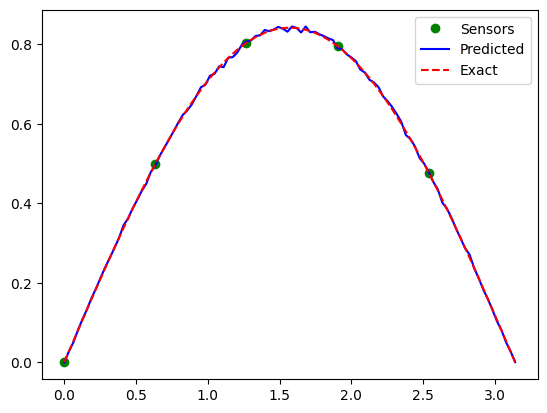

In [243]:
SD_model.cpu()
u_true = u_sol(t,x_full,n =1)
print(u_true.shape)
fig,ax = plt.subplots(1,1)
ax.plot(x_full[sensor_loc.numpy()], s[0,:].numpy(), 'o', label='Sensors', color='green')
ax.plot(x_full.numpy(),SD_model.forward(s, t)[0,:].cpu().detach().numpy(), label='Predicted', color='blue')
ax.plot(x_full.numpy(), u_true[0,:], label='Exact', color='red', linestyle='dashed')
ax.legend()